In [9]:
# ----------------- Code -----------------
import numpy as np
import matplotlib.pyplot as plt
from py_gpmf_parser.gopro_telemetry_extractor import GoProTelemetryExtractor
from scipy.spatial.transform import Rotation as R
from scipy.signal import butter, filtfilt

def extract_cori_quats(video_path):
    """Return (quats_wxyz (N,4), times (N,)) - quats in (w,x,y,z) ordering."""
    ext = GoProTelemetryExtractor(video_path)
    ext.open_source()
    try:
        data, t = ext.extract_data("CORI")
    finally:
        ext.close_source()
    q = np.asarray(data)
    t = np.asarray(t)
    if q.ndim == 1 and q.size == 4:
        q = q.reshape(1,4)
    return q, t

def cori_shakiness_metrics(video_path, hp_cutoff_hz=1.0, sliding_window_s=1.0, plot=True):
    """
    Compute shakiness metrics from CORI only (camera rotation).
    Returns: metrics_dict, time_array, angle_deg (per-frame), ang_vel_deg_s, hf_filtered_angle_deg, sliding_rms_deg
    """
    # --- extract ---
    q_wxyz, t = extract_cori_quats(video_path)
    if q_wxyz.size == 0:
        raise RuntimeError("No CORI data found in file.")
    # convert to scipy quat order (x,y,z,w)
    q_xyzw = q_wxyz[:, [1,2,3,0]]
    R_all = R.from_quat(q_xyzw)   # length N

    # --- relative rotations between consecutive frames: R_rel = R_curr * R_prev.inv() ---
    if len(R_all) == 1:
        # trivial single-sample case
        angle_deg = np.array([0.0])
        ang_vel = np.array([0.0])
        filtered_angle = np.array([0.0])
        sliding_rms = np.array([0.0])
        t_out = t
    else:
        R_prev = R_all[:-1]
        R_curr = R_all[1:]
        R_rel = R_curr * R_prev.inv()   # elementwise rotation multiplication
        # turn to rotation vectors (axis * angle), norm gives angle (radians)
        rotvecs = R_rel.as_rotvec()          # shape (N-1, 3)
        angles_rad = np.linalg.norm(rotvecs, axis=1)
        angles_deg = np.degrees(angles_rad)  # per-transition angle (deg)
        # pad to match original frames length: set first frame change = 0
        angle_deg = np.concatenate([[0.0], angles_deg])   # len N

        # --- angular velocity (deg/s) ---
        dt = np.diff(t)
        # protect zeros
        dt_safe = np.where(dt==0, 1e-6, dt)
        dangle = np.abs(np.diff(angle_deg))
        ang_vel = np.concatenate([[0.0], dangle / dt_safe])  # len N (first 0)

        # --- HF RMS on angle_deg time series ---
        # sampling frequency estimate
        median_dt = np.median(np.diff(t)) if t.size>1 else 1.0
        fs = 1.0 / median_dt if median_dt>0 else 30.0
        nyq = 0.5 * fs
        if hp_cutoff_hz >= nyq:
            # cutoff too high -> no high pass; set filtered to zero
            filtered_angle = np.zeros_like(angle_deg)
            hf_rms = 0.0
        else:
            b, a = butter(4, hp_cutoff_hz/nyq, btype='high', analog=False)
            # filtfilt needs length>order; if too short, skip filtering
            if len(angle_deg) <= max(len(a), len(b))*3:
                filtered_angle = angle_deg - np.mean(angle_deg)
            else:
                filtered_angle = filtfilt(b, a, angle_deg)
            hf_rms = float(np.sqrt(np.mean(filtered_angle**2)))

        # --- sliding-window RMS (per sliding_window_s seconds) ---
        # window length in samples
        win_s = float(sliding_window_s)
        if win_s <= 0:
            sliding_rms = np.zeros_like(angle_deg)
        else:
            win_samples = max(1, int(round(win_s * fs)))
            # compute RMS with convolution
            sq = angle_deg**2
            kernel = np.ones(win_samples) / win_samples
            # use 'same' to keep length
            mean_sq = np.convolve(sq, kernel, mode='same')
            sliding_rms = np.sqrt(mean_sq)

        t_out = t

    # --- metrics summary ---
    metrics = {
        "n_samples": int(len(t_out)),
        "fs_est_hz": float(1.0/np.median(np.diff(t_out))) if len(t_out)>1 else None,
        "mean_frame_angle_deg": float(np.mean(angle_deg)),
        "median_frame_angle_deg": float(np.median(angle_deg)),
        "max_frame_angle_deg": float(np.max(angle_deg)),
        "mean_ang_vel_deg_s": float(np.mean(ang_vel)),
        "max_ang_vel_deg_s": float(np.max(ang_vel)),
        "hf_rms_angle_deg": float(hf_rms)
    }

    # --- plotting ---
    if plot:
        fig, axs = plt.subplots(4,1, figsize=(12,10), sharex=True)
        axs[0].plot(t_out, angle_deg, label="frame-to-frame rotation angle (deg)")
        axs[0].set_ylabel("Angle (deg)")
        axs[0].legend(); axs[0].grid(True)

        axs[1].plot(t_out, ang_vel, label="angular velocity (deg/s)", color="C1")
        axs[1].set_ylabel("deg/s")
        axs[1].legend(); axs[1].grid(True)

        axs[2].plot(t_out, angle_deg, alpha=0.3, label="angle (raw)")
        axs[2].plot(t_out, filtered_angle, label=f"high-pass > {hp_cutoff_hz} Hz", color="C2")
        axs[2].set_ylabel("Angle (deg)")
        axs[2].legend(); axs[2].grid(True)

        axs[3].plot(t_out, sliding_rms, label=f"{sliding_window_s}s sliding RMS (deg)", color="C3")
        axs[3].set_ylabel("RMS Angle (deg)")
        axs[3].set_xlabel("Time (s)")
        axs[3].legend(); axs[3].grid(True)

        plt.suptitle("Camera shakiness from CORI (camera-body rotations)")
        plt.tight_layout(rect=[0,0,1,0.96])
        plt.show()

        # histogram
        plt.figure(figsize=(8,3))
        plt.hist(angle_deg, bins=60)
        plt.title("Distribution of frame-to-frame rotation angles")
        plt.xlabel("Angle (deg)")
        plt.ylabel("Count")
        plt.grid(True)
        plt.show()

    return metrics, t_out, angle_deg, ang_vel, filtered_angle, sliding_rms


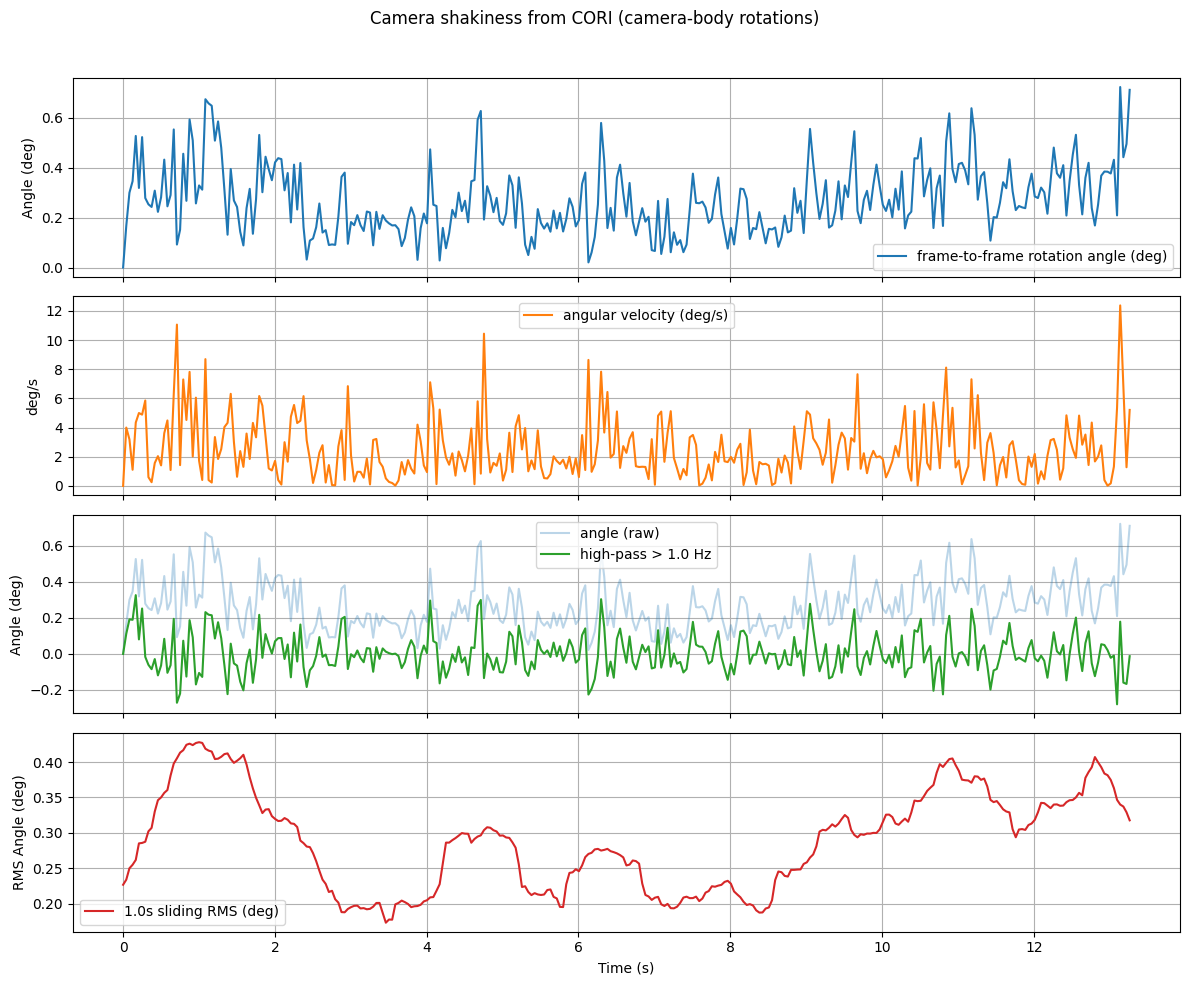

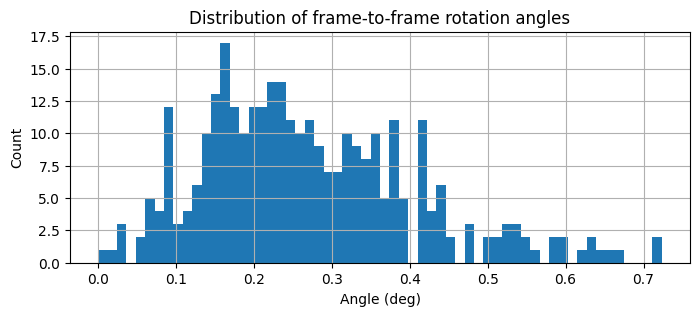

{'n_samples': 319, 'fs_est_hz': 23.97602397602403, 'mean_frame_angle_deg': 0.27014041331786587, 'median_frame_angle_deg': 0.24521935061897135, 'max_frame_angle_deg': 0.7235262093834833, 'mean_ang_vel_deg_s': 2.4694581094318333, 'max_ang_vel_deg_s': 12.377585270041616, 'hf_rms_angle_deg': 0.10587314677439014}


In [ ]:
# ----------------- Example usage -----------------
video_file = "/home/tocisz/Wideo/Safari 2025/GX011107.MP4"   # <-- change to your file
metrics, t, angle_deg, ang_vel, filtered_angle, sliding_rms = cori_shakiness_metrics(video_file, hp_cutoff_hz=1.0)
print(metrics)


In [1]:
" ".join([
                "ffprobe", "-v", "error",
                "-select_streams", "v:0",
                "-show_entries", "frame=pkt_pts_time",
                "-of", "json",
                "-skip_frame", "nokey",  # Only keyframes
                "path"
            ])

'ffprobe -v error -select_streams v:0 -show_entries frame=pkt_pts_time -of json -skip_frame nokey path'

In [31]:
# Required libraries:
# !pip install py-gpmf-parser scipy numpy pandas matplotlib

import numpy as np
import matplotlib.pyplot as plt
from py_gpmf_parser.gopro_telemetry_extractor import GoProTelemetryExtractor
from scipy.spatial.transform import Rotation as R
from scipy.signal import butter, filtfilt
from math import nan

# ============================================================
# Utility Functions
# ============================================================
def extract_cori_quats(video_path):
    ext = GoProTelemetryExtractor(str(video_path))
    ext.open_source()
    try:
        q, t = ext.extract_data("CORI")
    finally:
        ext.close_source()

    q = np.asarray(q)
    t = np.asarray(t)

    if q.ndim == 1:
        q = q.reshape(1, 4)

    return q, t


def cori_sliding_rms(video_path, sliding_window_s=1.0):
    """
    Returns:
      t              → timestamps
      angle_deg      → per-frame rotation angle
      sliding_rms    → sliding RMS of angle_deg
    """
    q_wxyz, t = extract_cori_quats(video_path)
    if q_wxyz.size == 0:
        return None, None, None

    # Convert to scipy xyz-w
    q_xyzw = q_wxyz[:, [1,2,3,0]]
    R_all = R.from_quat(q_xyzw)

    # Frame-to-frame relative rotation
    if len(R_all) > 1:
        R_prev = R_all[:-1]
        R_curr = R_all[1:]
        R_rel = R_curr * R_prev.inv()
        rotvecs = R_rel.as_rotvec()
        angle_deg = np.concatenate([[0.0], np.degrees(np.linalg.norm(rotvecs, axis=1))])
    else:
        angle_deg = np.array([0.0])

    # Frame-to-frame acceleration
    if len(R_rel) > 1:
        a_prev = R_rel[:-1]
        a_curr = R_rel[1:]
        accel = a_curr * a_prev.inv()
        avecs = accel.as_rotvec()
        angle_acc = np.concatenate([[0.0, 0.0], np.degrees(np.linalg.norm(avecs, axis=1))])
    else:
        angle_acc = np.array([0.0, 0.0])

    # Sampling frequency
    dt = np.median(np.diff(t)) if len(t) > 1 else 1.0
    fs = 1.0 / dt

    # ---- Sliding RMS ----
    win_samples = max(1, int(sliding_window_s * fs))
    sq = angle_acc ** 2
    kernel = np.ones(win_samples) / win_samples
    sliding_rms = np.sqrt(np.convolve(sq, kernel, mode='same'))
    half_len = win_samples // 2
    print("half_len:", half_len)
    sliding_rms = np.concatenate([sliding_rms[half_len:len(t)], [sliding_rms[-1]] * half_len])  # Ensure same length

    return t, angle_deg, angle_acc, sliding_rms


# ============================================================
# Main Analysis Function
# ============================================================

def estimate_shakiness(video_path, plot=True, sliding_window_s=1.0):
    """
    Computes:
      - correction angle
      - angular velocity
      - angular acceleration (primary shakiness metric)
      - high-frequency filtered angular acceleration RMS

    Returns detailed metrics + all time series.
    """

    t, angle_deg, angle_acc, sliding_rms = cori_sliding_rms(video_path, sliding_window_s=sliding_window_s)

    # --------------------------------------
    # Visualization
    # --------------------------------------
    if plot:
        fig, axes = plt.subplots(3, 1, figsize=(15, 16), sharex=True)

        # --- Angular Velocity ---
        axes[0].plot(t, angle_deg, color="tab:blue", linewidth=1.2)
        axes[0].set_ylabel("Velocity (deg/s)")
        axes[0].set_title("Angluar Velocity")

        # --- Angular Acceleration ---
        axes[1].plot(t, angle_acc, color="tab:green", linewidth=1.2)
        axes[2].set_ylabel("Accel (deg/s²)")
        axes[1].set_title("Angular Acceleration")

        # --- NEW: Sliding-window RMS of high-frequency acceleration ---
        axes[2].plot(t, sliding_rms, color="tab:purple", linewidth=1.4)
        axes[2].set_ylabel("RMS (deg/s²)")
        axes[2].set_title(
            f"Sliding RMS of HF Acceleration (window = {sliding_window_s}s)"
        )
        axes[2].set_xlabel("Time (s)")

        # Improve layout
        for ax in axes:
            ax.grid(True, alpha=0.3)

        fig.tight_layout()


    # Histogram of acceleration
    if plot:
        plt.figure(figsize=(8,4))
        plt.hist(angle_acc, bins=80)
        plt.title("Angular Acceleration Distribution (deg/s²)")
        plt.grid(True)
        plt.show()

    return t, angle_deg, angle_acc, sliding_rms

half_len: 11


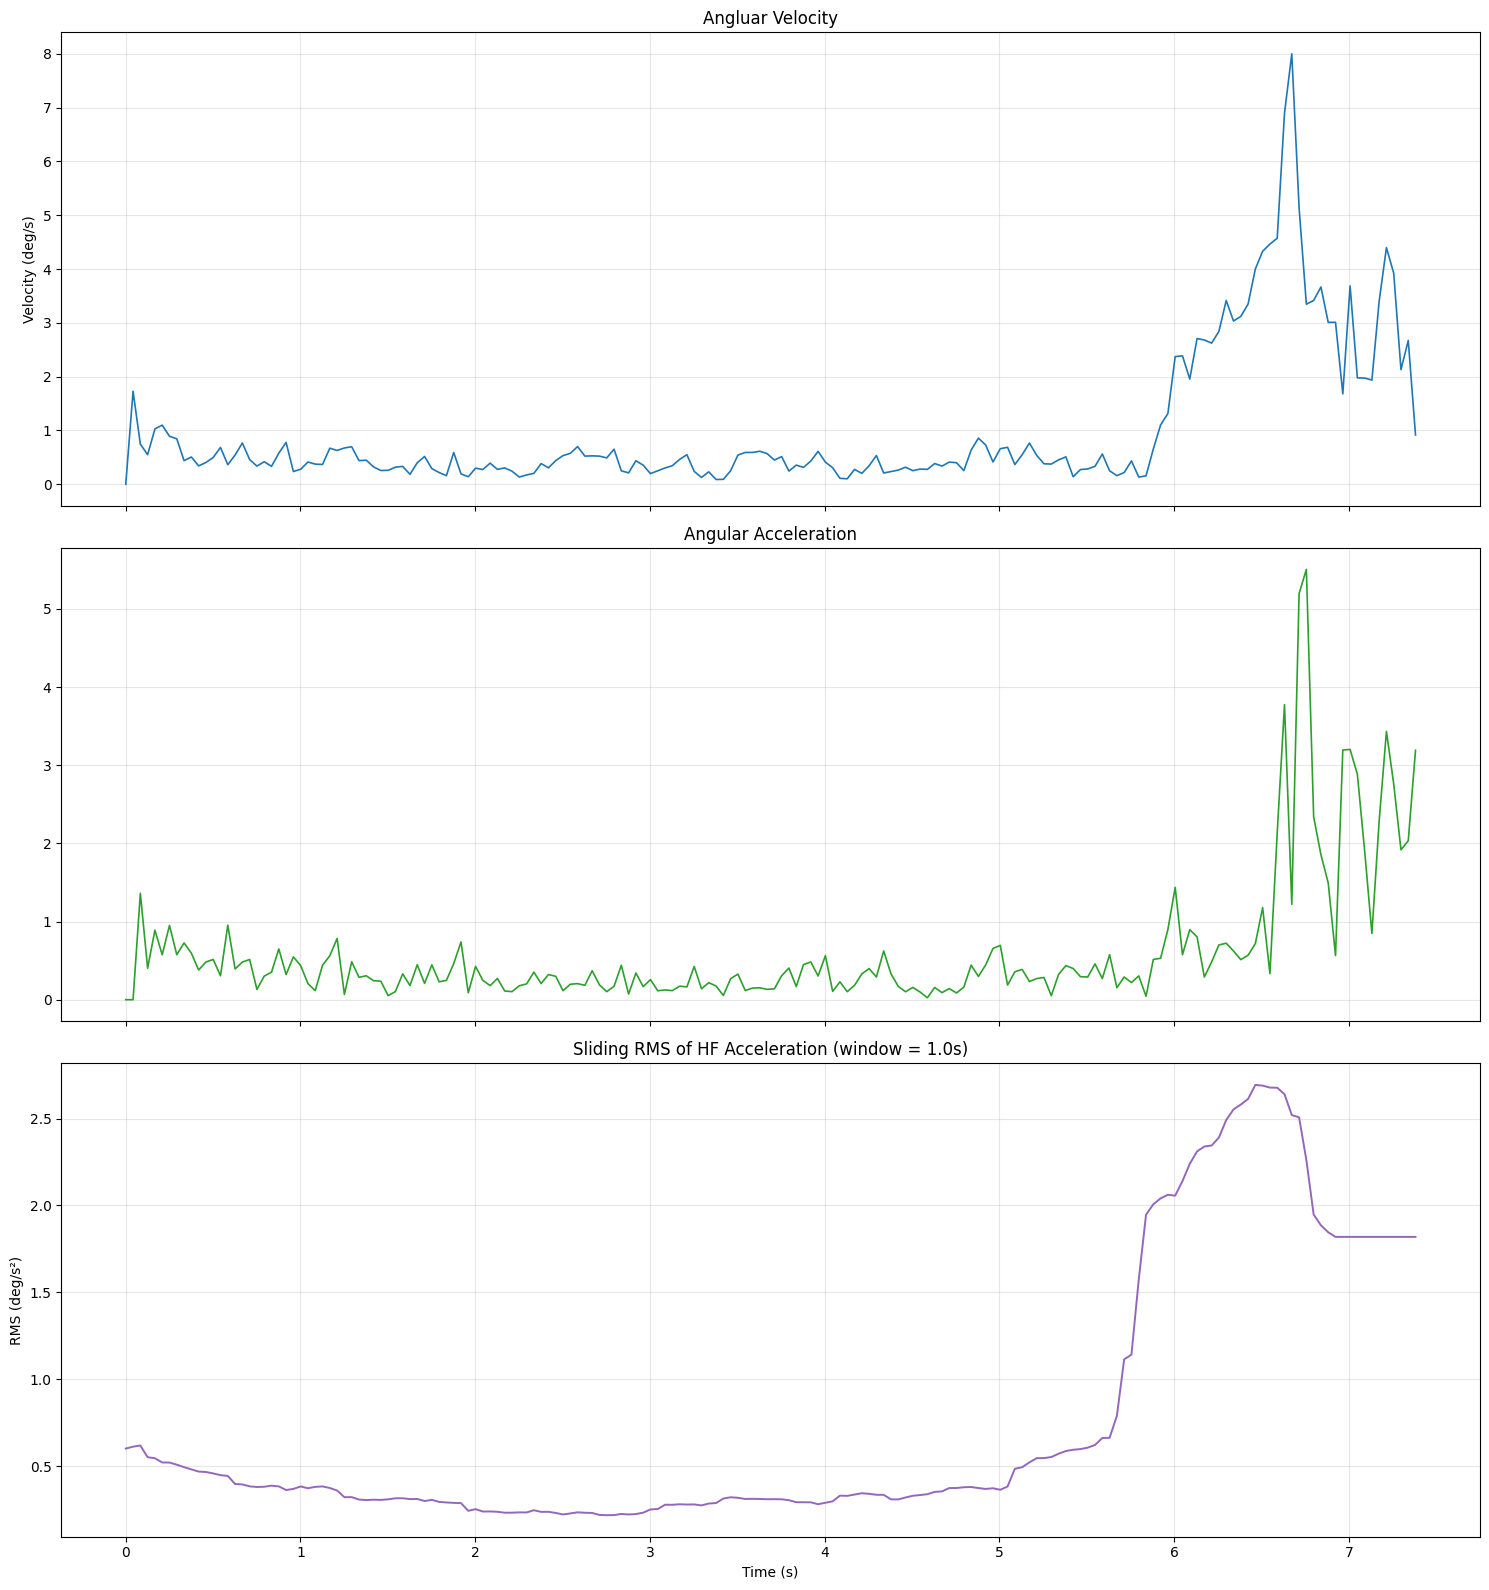

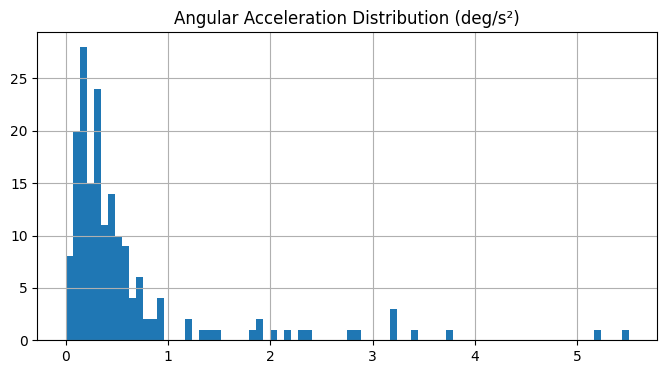

In [32]:

# ============================================================
# Example usage
# ============================================================

video_file = "/home/tocisz/Wideo/Safari 2025/GX011108.MP4"  # change this
t, angle_deg, angle_acc, sliding_rms = estimate_shakiness(
    video_file,
    plot=True,
)